# <center>The Smith Parasite - An Unknown Parasitic Disease</center>

A new disease has recently been discovered by Dr. Smith, in England. You have been brought in to investigate.
The disease has already affected more than 5000 people, with no apparent connection between them.

The most common symptoms include fever and tiredness, but some infected people are asymptomatic. Regardless, this virus is being associated with post-disease conditions such as loss of speech, confusion, chest pain and shortness of breath.

The conditions of the transmission of the disease are still unknown and there are no certainties of what leads a patient to suffer or not from it. Nonetheless, some groups of people seem more prone to be infected by the parasite than others.

In this challenge, your goal is to build a predictive model that answers the question, “Who are the people more likely to suffer from the Smith Parasite?”. With that goal, you can access a small quantity of sociodemographic, health, and behavioral information obtained from the patients.

As data scientists, your team is asked to analyze and transform the data available as needed and apply different models to answer the defined question in a more accurate way. Can you build a model that can predict if a patient will suffer, or not, from the Smith Disease?

---

### Datasets
The training set should be used to build your machine learning models. In this set, you also have the ground truth associated to each patient, i.e., if the patient has the disease (Disease = 1) or not (Disease = 0).

The test set should be used to see how well your model performs on unseen data. In this set you don’t have access to the ground truth, and the goal of your team is to predict that value (0 or 1) by using the model you created using the training set.

The score of your predictions is the percentage of instances you correctly predict, using the **f1 score**.

---

### Deliverables

You should submit a csv file with the number of instances in the test set, containing the columns [PatientID, Disease], and only those columns. <br>
The Disease column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

---

In [67]:
import os
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV

In [2]:
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name}
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df_train = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')
data_frames = [data['test_demo'], data['test_habits'], data['test_health']]
df_test = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

In [3]:
df_train

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.
1557,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.
1658,Mr. David Caffee,1958,London,University Complete (3 or more years),0,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,180,66,313,125,13,8,Not sure,I have/had pregnancy diabetes or borderline di...
1544,Mr. Gerald Emery,1968,South East,University Incomplete (1 to 2 years),1,No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,More than half a liter but less than one liter,180,58,277,125,18,2,More than 3 years,I have/had pregnancy diabetes or borderline di...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,Mr. Philip Klink,1972,East Midlands,High School Incomplete (10th to 11th grade),0,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,178,61,204,144,12,4,Not sure,Neither I nor my immediate family have diabetes.
1386,Mrs. Jackie Valencia,1980,North West,Elementary School (1st to 9th grade),1,No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,157,61,213,120,23,0,More than 3 years,I have/had pregnancy diabetes or borderline di...
1088,Mrs. Cheryl Harris,1860,East Midlands,Elementary School (1st to 9th grade),0,No,I consider myself a social drinker,No,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,167,48,272,140,20,17,More than 3 years,Neither I nor my immediate family have diabetes.


In [4]:
def feature_engeneering(df):
    df = df.assign(binary_male=lambda x: (x["Name"].str.split('.').str[0] == "Mr").astype(int))
    df = df.assign(BMI=lambda x: x["Weight"]/(x["Height"]/100)**2)
    df["Birth_Year"] = df["Birth_Year"].apply(lambda x: x+100 if x < 1900 else x)
    df = df.assign(age=lambda x: date.today().year-x["Birth_Year"])
    df["Region"] = df["Region"].apply(lambda x: str.lower(x))

    return df

In [5]:
df_train = feature_engeneering(df_train)

y = df_train["Disease"]
X = df_train.drop("Disease", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state=123, stratify = y, shuffle = True)

X_train_num, X_train_cat = X_train.select_dtypes(include=np.number), X_train.select_dtypes(exclude=np.number)
X_val_num, X_val_cat = X_val.select_dtypes(include=np.number), X_val.select_dtypes(exclude=np.number)


In [6]:
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, index=X_val_num.index, columns=X_val_num.columns)

# Feature Selection

## 1. Filter Methods
### 1.1 Univariate variables

In [7]:
X_train_num_scaled.var()

Birth_Year          0.033700
Height              0.077645
Weight              0.046725
High_Cholesterol    0.013289
Blood_Pressure      0.027955
Mental_Health       0.035446
Physical_Health     0.033385
binary_male         0.209657
BMI                 0.078626
age                 0.033700
dtype: float64

#### Since none of the features has a variance of 0 none of them is univariate so we can't discard features by just doing that analysis

### 1.2 Spearman Correlation

In [8]:
Xy_train_num = X_train_num_scaled.join(y_train)
cor_spearman = Xy_train_num.corr(method ='spearman')
cor_spearman

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,binary_male,BMI,age,Disease
Birth_Year,1.000000,0.092236,0.193733,-0.222440,-0.315051,0.379599,-0.246594,0.166981,0.155260,-1.000000,0.241587
Height,0.092236,1.000000,0.488772,-0.048020,-0.046801,-0.045597,0.063282,0.654036,-0.000084,-0.092236,-0.161268
Weight,0.193733,0.488772,1.000000,-0.033328,-0.099823,0.321416,-0.451202,0.386157,0.853715,-0.193733,0.200789
High_Cholesterol,-0.222440,-0.048020,-0.033328,1.000000,0.171779,-0.018372,0.029946,-0.143943,0.011657,0.222440,-0.106701
Blood_Pressure,-0.315051,-0.046801,-0.099823,0.171779,1.000000,-0.034869,0.153333,-0.101425,-0.100338,0.315051,-0.125430
Mental_Health,0.379599,-0.045597,0.321416,-0.018372,-0.034869,1.000000,-0.441918,-0.036864,0.384576,-0.379599,0.432844
Physical_Health,-0.246594,0.063282,-0.451202,0.029946,0.153333,-0.441918,1.000000,0.061640,-0.551538,0.246594,-0.429300
binary_male,0.166981,0.654036,0.386157,-0.143943,-0.101425,-0.036864,0.061640,1.000000,0.049162,-0.166981,-0.297674
BMI,0.155260,-0.000084,0.853715,0.011657,-0.100338,0.384576,-0.551538,0.049162,1.000000,-0.155260,0.329515
age,-1.000000,-0.092236,-0.193733,0.222440,0.315051,-0.379599,0.246594,-0.166981,-0.155260,1.000000,-0.241587


### 1.3 Chi-Square for Categorical Data

In [9]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [10]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Name is NOT an important predictor. (Discard Name from model)
Region is NOT an important predictor. (Discard Region from model)
Education is NOT an important predictor. (Discard Education from model)
Smoking_Habit is NOT an important predictor. (Discard Smoking_Habit from model)
Drinking_Habit is IMPORTANT for Prediction
Exercise is IMPORTANT for Prediction
Fruit_Habit is IMPORTANT for Prediction
Water_Habit is NOT an important predictor. (Discard Water_Habit from model)
Checkup is IMPORTANT for Prediction
Diabetes is IMPORTANT for Prediction


#### Chi-Square proposes to use Drinking_Habits, Exercise, Fruit_Habit, Checkup, Diabetes; *and* discard Name, Region, Education, Smoking_Habit and water_habit

### 1.4 Visual exploration

In [11]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()


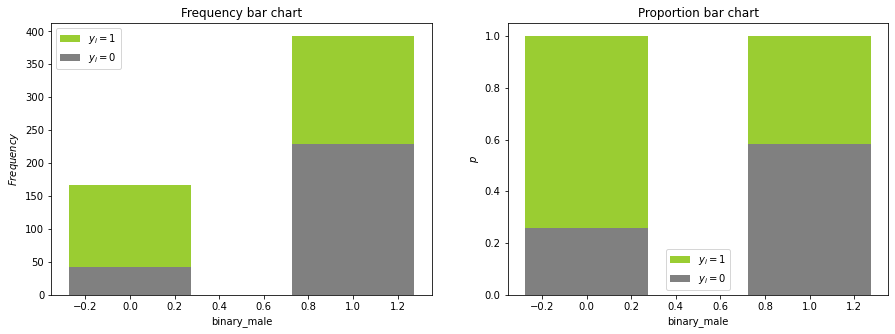

In [12]:
bar_charts_categorical(Xy_train_num, "binary_male", "Disease")

#### As you can see there seems to be a difference in the occurence of the Parasite in males and females. While approximatly 1/3 of the females are infected, more than 50% of the males are infected

## 2. Wrapper Methodes

### 2.1 RFECV with LogisticRegression and only Numerical Variables

In [13]:
model = LogisticRegression(penalty="none")
selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X_train_num_scaled, y_train)
X_train_num_scaled.columns[selector.support_]

Index(['Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'binary_male', 'BMI'],
      dtype='object')

In [14]:
selector.ranking_

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 2])

#### The RFECV with a LogisticRegression proposes to use Height, Weight, High_Cholesterol, Blood_Pressure, Mental_Health, Physical_Health, binary_male and BMI, so we would discard Birth_Year and age which are also having a perfect correlation since age is calculated using birth_year

In [15]:
def opt_number_features(model, X, y, X_val, y_val, n_max_feature=10):
    #no of features
    nof_list=list(range(1,n_max_feature+1))
    high_score=0
    #Variable to store the optimum features
    nof=0           
    score_list =[]
    for n in nof_list:
        rfe = RFE(estimator=model,n_features_to_select = n)
        X_train_rfe = rfe.fit_transform(X,y)
        X_val_rfe = rfe.transform(X_val)
        model.fit(X_train_rfe,y_train)
        
        score = model.score(X_val_rfe,y_val)
        score_list.append(score)
        
        if(score>high_score):
            high_score = score
            nof = n
            features = rfe.feature_names_in_
            bool_table = rfe.support_
            rank_table = rfe.ranking_
    print("Optimum number of features: %d" %nof)
    print("the selected features are:", features , rank_table, bool_table)
    print("Score with %d features: %f" % (nof, high_score))

    return bool_table, rank_table

In [16]:
bool_table, rank_table = opt_number_features(model,X_train_num_scaled,y_train,X_val_num_scaled,y_val)

Optimum number of features: 7
the selected features are: ['Birth_Year' 'Height' 'Weight' 'High_Cholesterol' 'Blood_Pressure'
 'Mental_Health' 'Physical_Health' 'binary_male' 'BMI' 'age'] [4 1 1 1 2 1 1 1 1 3] [False  True  True  True False  True  True  True  True False]
Score with 7 features: 0.775000


In [17]:
selected_features_num = pd.DataFrame(selector.support_, index=X_train_num_scaled.columns, columns=["RFECV_LR"])
selected_features_num["RFECV_LR_rk"] = selector.ranking_
selected_features_num["RFE_opt_feat_LR"] = bool_table
selected_features_num["RFE_opt_feat_LR_rk"] = rank_table

### 2.2 RFECV with RandomForrest and only Numerical Variables

In [18]:
model = RandomForestClassifier()
selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X_train_num_scaled, y_train)

In [19]:
X_train_num_scaled.columns[selector.support_]

Index(['Birth_Year', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'BMI', 'age'],
      dtype='object')

In [20]:
bool_table, rank_table = opt_number_features(model,X_train_num_scaled,y_train,X_val_num_scaled,y_val)

Optimum number of features: 5
the selected features are: ['Birth_Year' 'Height' 'Weight' 'High_Cholesterol' 'Blood_Pressure'
 'Mental_Health' 'Physical_Health' 'binary_male' 'BMI' 'age'] [3 6 4 1 2 1 1 5 1 1] [False False False  True False  True  True False  True  True]
Score with 5 features: 0.954167


In [21]:
selected_features_num["RFECV_RF"] = selector.support_
selected_features_num["RFECV_RF_rk"] = selector.ranking_
selected_features_num["RFE_opt_feat_RF"] = bool_table
selected_features_num["RFE_opt_feat_RF_rk"] = rank_table

In [22]:
selected_features_num

,RFECV_LR,RFECV_LR_rk,RFE_opt_feat_LR,RFE_opt_feat_LR_rk,RFECV_RF,RFECV_RF_rk,RFE_opt_feat_RF,RFE_opt_feat_RF_rk
Birth_Year,False,3,False,4,True,1,False,3
Height,True,1,True,1,False,2,False,6
Weight,True,1,True,1,False,3,False,4
High_Cholesterol,True,1,True,1,True,1,True,1
Blood_Pressure,True,1,False,2,True,1,False,2
Mental_Health,True,1,True,1,True,1,True,1
Physical_Health,True,1,True,1,True,1,True,1
binary_male,True,1,True,1,False,4,False,5
BMI,True,1,True,1,True,1,True,1
age,False,2,False,3,True,1,True,1


#### you can see the features the RFE and RFECV selected for the two different estimators in the df above

## 3. Embedded
### 3.1 Lasso

In [23]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [24]:
lasso = LassoCV()
lasso.fit(X_train_num_scaled, y_train)

coef = pd.Series(lasso.coef_, index = X_train_num_scaled.columns)
coef.sort_values()

Physical_Health    -0.590980
binary_male        -0.396025
High_Cholesterol   -0.382702
Blood_Pressure     -0.278158
age                -0.002466
Weight             -0.000000
Height              0.138210
Birth_Year          0.194223
BMI                 0.201260
Mental_Health       0.687091
dtype: float64

In [25]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 1 variables


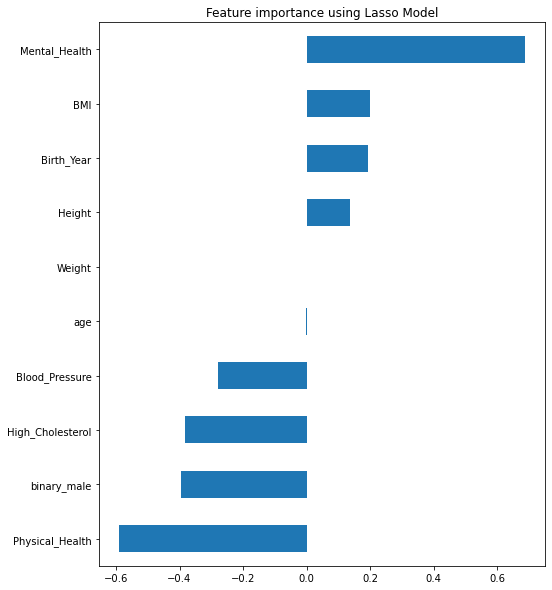

In [26]:
plot_importance(coef,'Lasso')

In [27]:
selected_features_num["LassoCV"] = coef != 0

Numerical Data

| Predictor |  RFECV_LR | RFE_opt_feat_LR | RFECV_RF | RFE_opt_feat_RF |  LassoCV |  Decision |
| --- | --- |--- | --- | --- | --- | --- |
| Birth_Year | Discard | Discard | Keep | Keep |  Keep |  K=3; D=2 |
| Height | Keep | Keep | Keep | Discard |  Keep |  K=4; D=1 |
| Weight | Keep | Keep | Keep | Discard |  Discard |  K=3; D=2 |
| High_Cholesterol | Keep | Keep | Keep | Keep |  Keep |  K=5; D=0 |
| Blood_Pressure | Keep | Discard | Keep | Keep |  Keep |  K=4; D=1 |
| Mental_Health | Keep | Keep | Keep | Keep |  Keep |  K=5; D=0 |
| Physical_Health |  Keep | Keep | Keep | Keep |  Keep |  K=5; D=0 |
| binary_male | Keep | Keep | Keep | Keep |  Keep |  K=5; D=0 |
| BMI | Keep | Keep | Keep | Keep |  Keep |  K=5; D=0 |
| age | Discard | Discard | Keep | Keep |  Keep |  K=3; D=2 |



Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| Drinking_Habits | Keep |  
| Exercise | Keep | 
| Fruit_Habit | Keep|
| Checkup | Keep | 
| Diabetes | Keep | 
| Name | Discard |
| Region | Discard |
| Education | Discard |
| Smoking_Habit | Discard |
| water_habit | Discard |

# Imputing and Encoding and Repeating analysis

In [28]:
X_train_cat["Education"] = X_train_cat["Education"].fillna("I never attended school / Other")
X_train_cat.drop(columns = ['Name'], inplace = True)
X_train_cat_encoded = pd.concat([pd.get_dummies(X_train_cat[col], prefix=col) for col in X_train_cat.columns], axis = 1)
X_train_scaled = pd.merge(X_train_num_scaled, X_train_cat_encoded, left_index=True, right_index=True)

In [29]:
X_val_cat.drop(columns = ['Name'], inplace = True)
X_val_cat_encoded = pd.concat([pd.get_dummies(X_val_cat[col], prefix=col) for col in X_val_cat.columns], axis = 1)
X_val_scaled = pd.merge(X_val_num_scaled, X_val_cat_encoded, left_index=True, right_index=True)

In [30]:
X_val_scaled.columns == X_train_scaled.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

## 1. Filter Methods
### 1.1 Univariate variables

In [31]:
X_train_scaled.var().sort_values()

Checkup_Less than three months                                                         0.008865
Drinking_Habit_I do not consume any type of alcohol                                    0.010618
High_Cholesterol                                                                       0.013289
Fruit_Habit_More than six pieces of fruit                                              0.019291
Region_north east                                                                      0.024419
Blood_Pressure                                                                         0.027955
Physical_Health                                                                        0.033385
Birth_Year                                                                             0.033700
age                                                                                    0.033700
Mental_Health                                                                          0.035446
Weight                                  

#### Since none of the features has a variance of 0 none of them is univariate so we can't discard features by just doing that analysis
### 1.2 Spearman Correlation

In [32]:
Xy_train_scaled = X_train_scaled.join(y_train)
corr_spearman = Xy_train_scaled.corr(method ='spearman')
corr_spearman["Disease"].sort_values()

Diabetes_Neither I nor my immediate family have diabetes.                             -0.514496
Exercise_Yes                                                                          -0.443071
Physical_Health                                                                       -0.429300
Checkup_Not sure                                                                      -0.425356
binary_male                                                                           -0.297674
Fruit_Habit_3 to 4 pieces of fruit in average                                         -0.296725
age                                                                                   -0.241587
Fruit_Habit_1 to 2 pieces of fruit in average                                         -0.238795
Drinking_Habit_I consider myself a social drinker                                     -0.216853
Fruit_Habit_5 to 6 pieces of fruit in average                                         -0.178187
Height                                  

#### None of the features has a high correlation with the target

### 1.3 Visual exploration

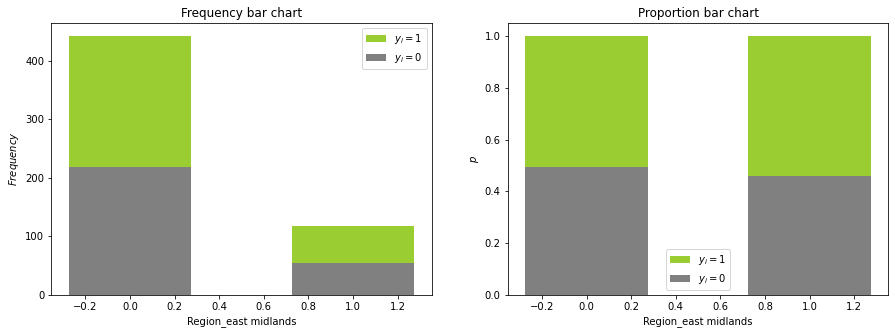

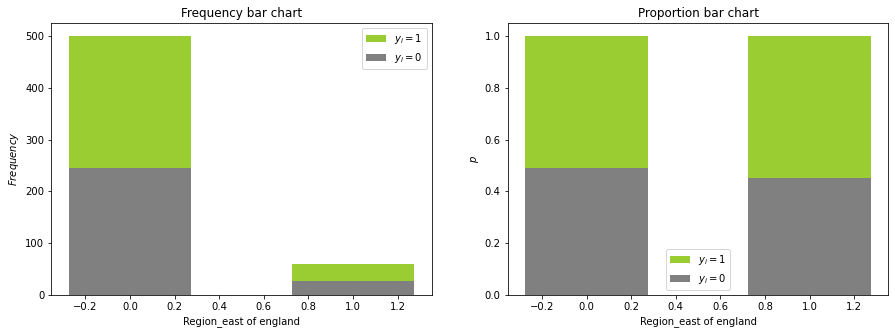

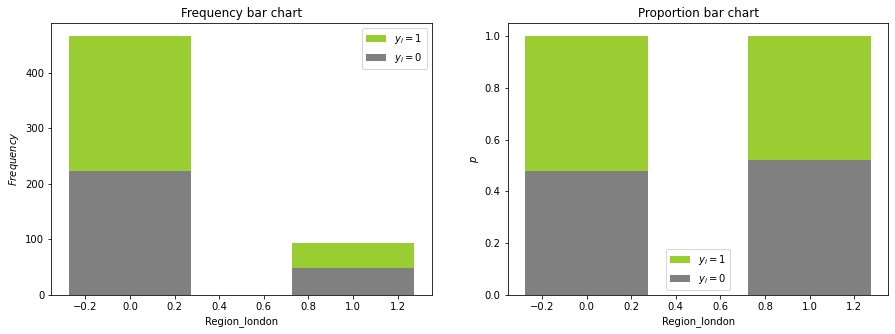

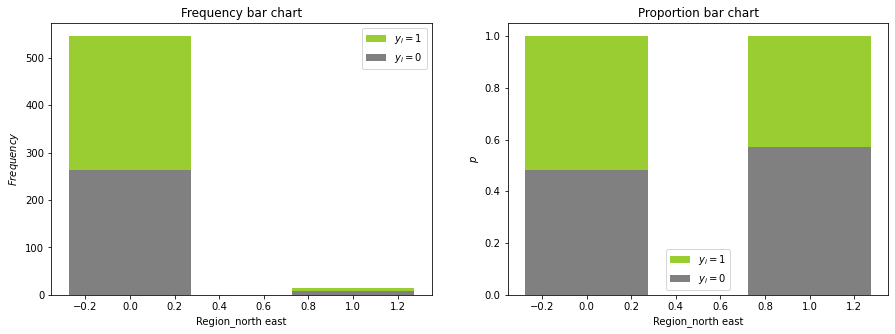

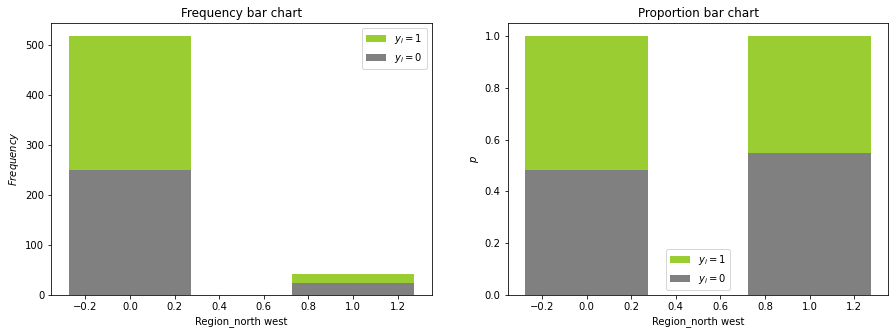

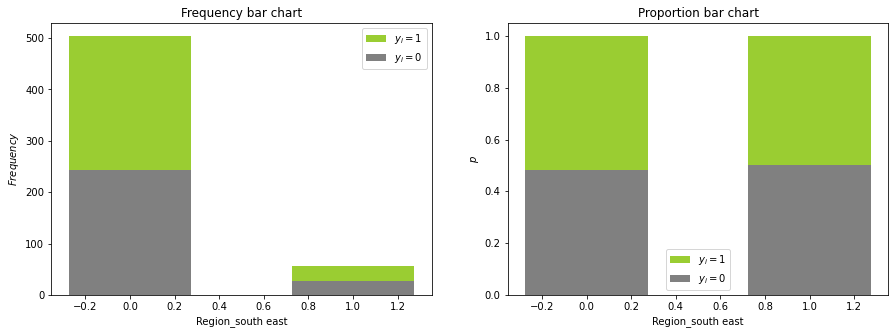

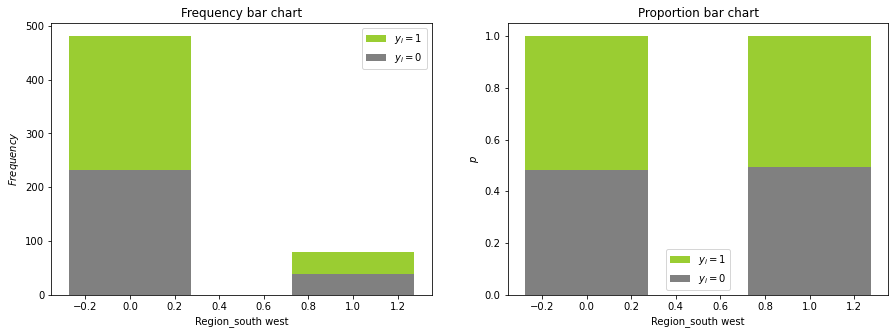

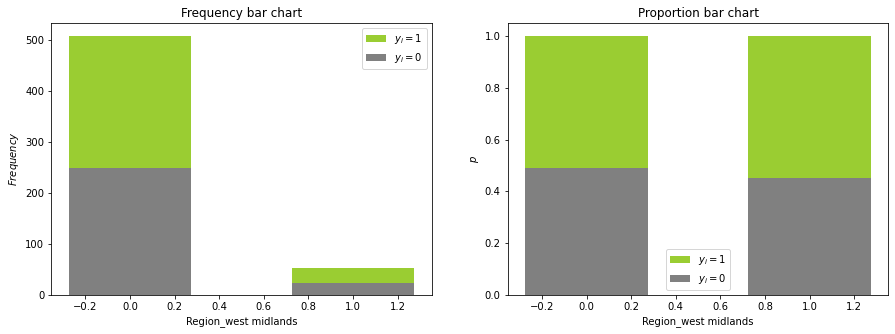

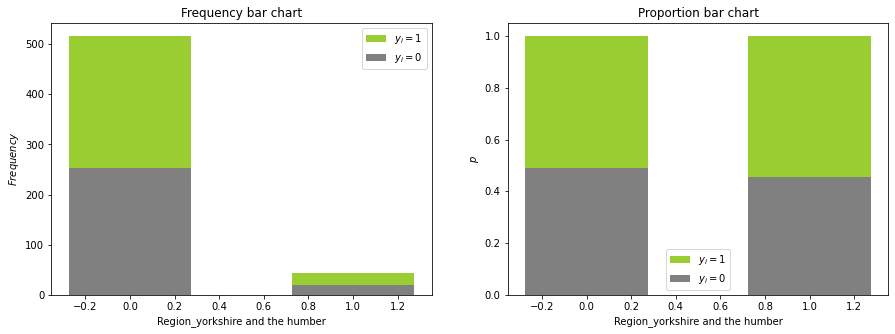

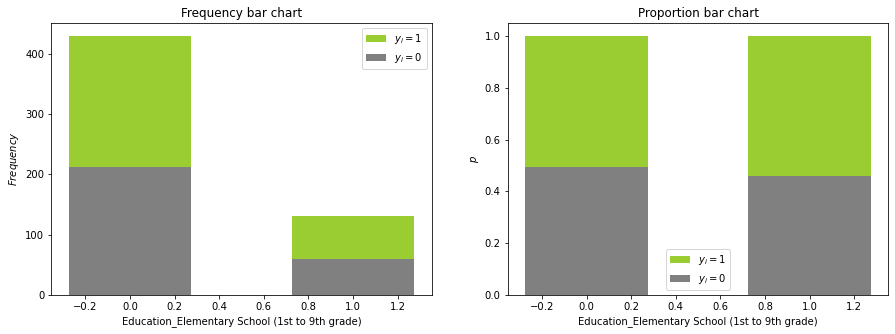

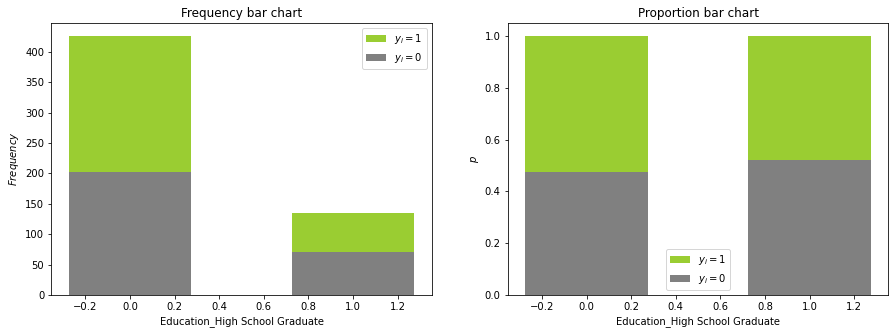

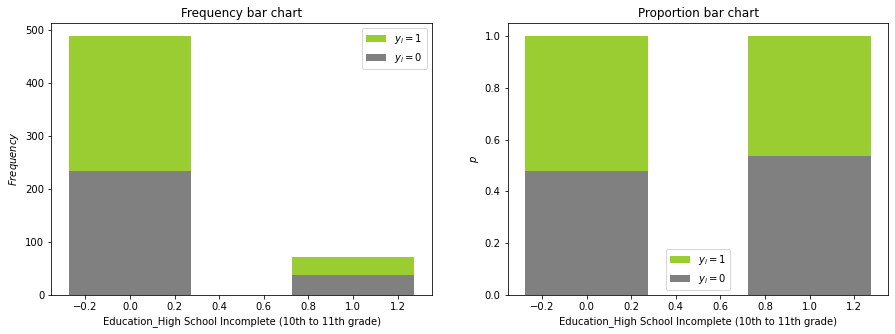

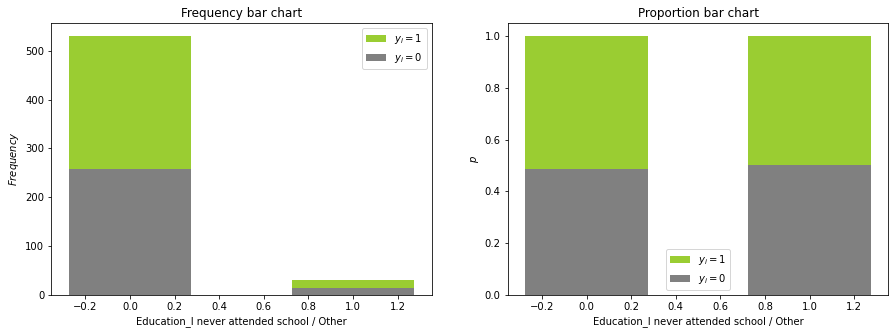

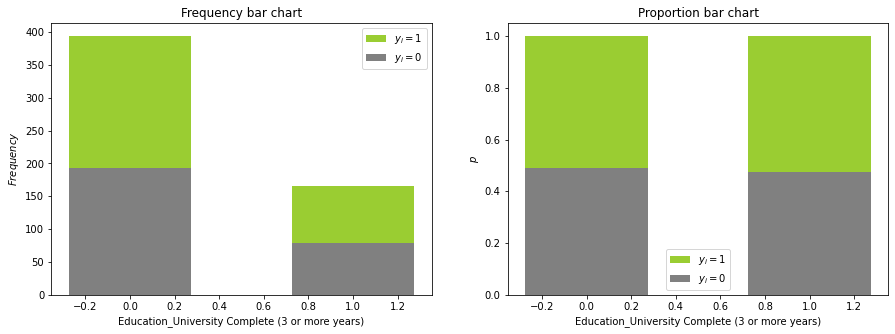

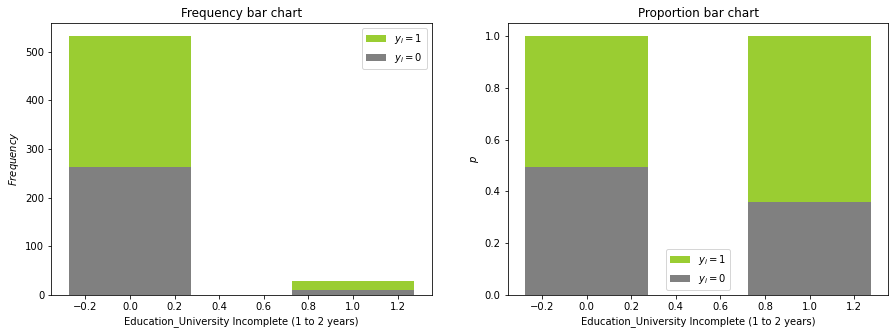

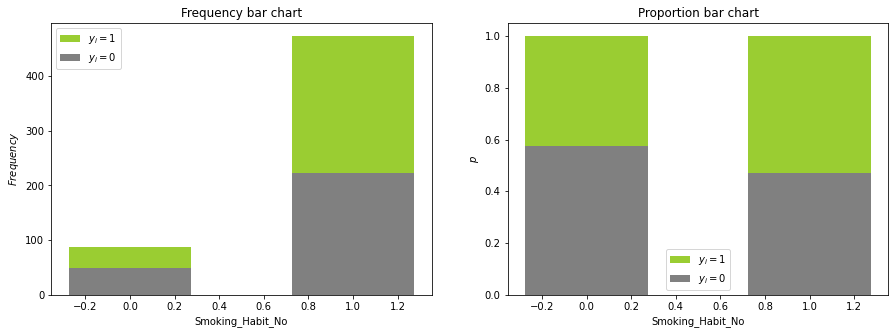

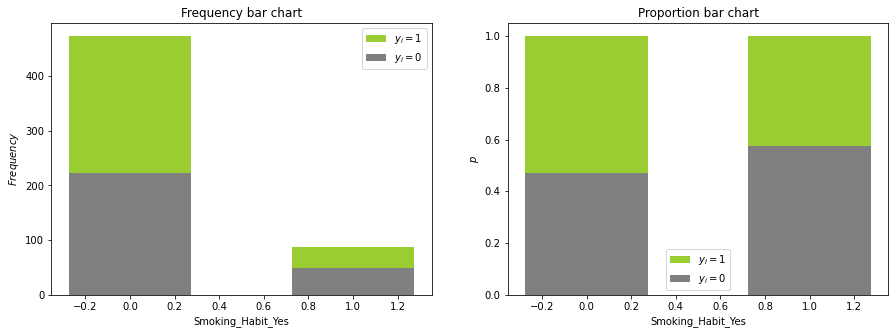

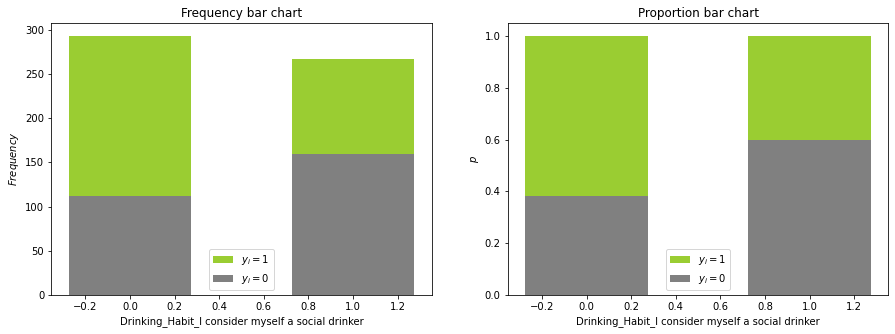

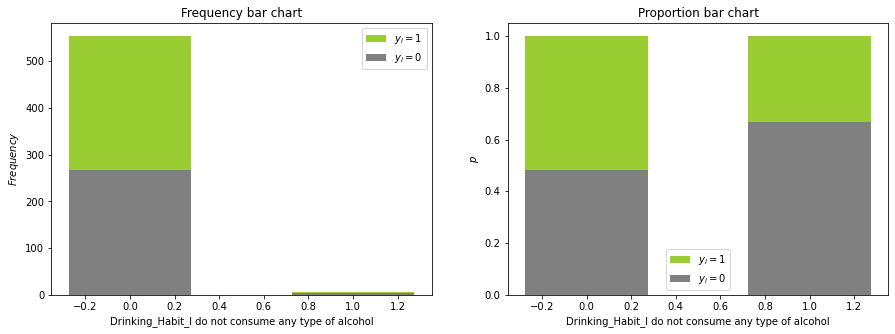

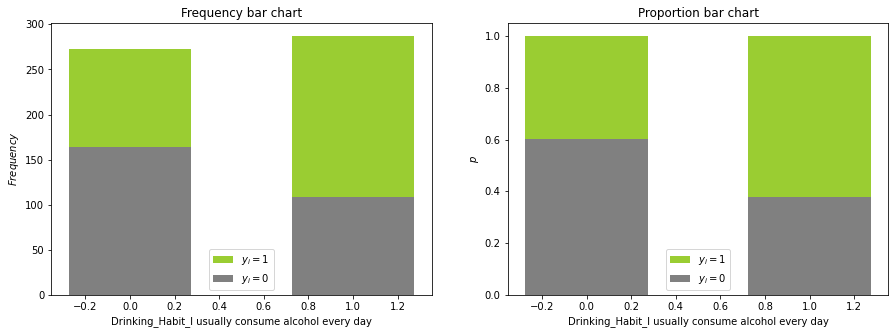

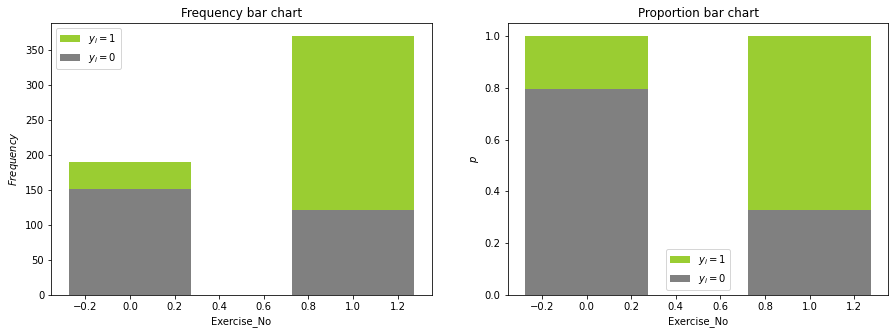

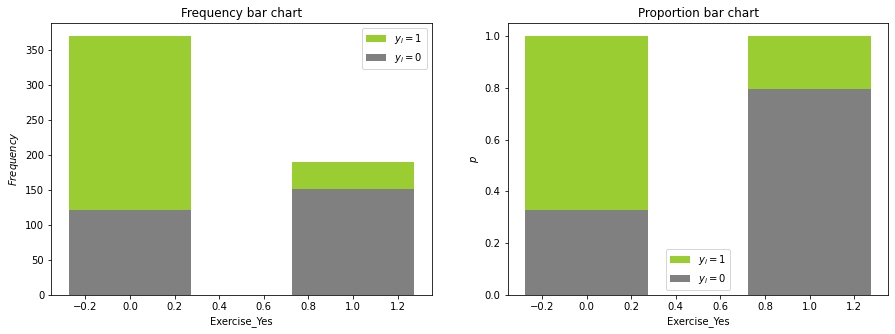

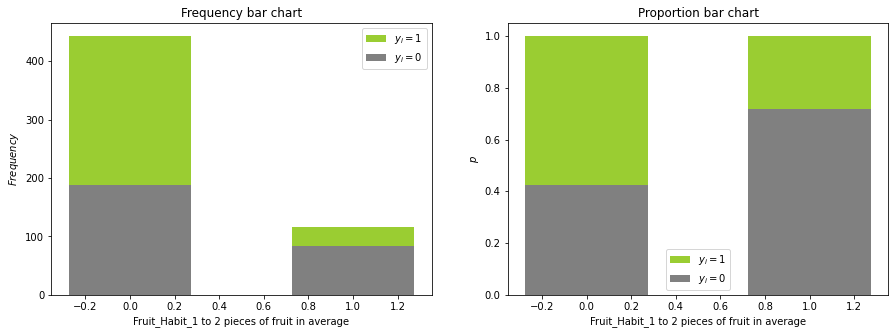

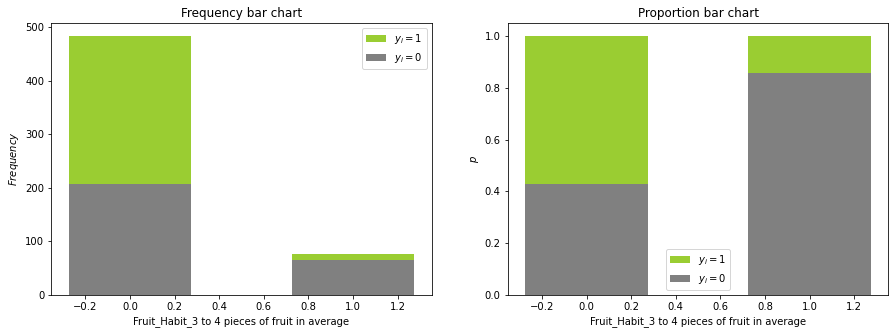

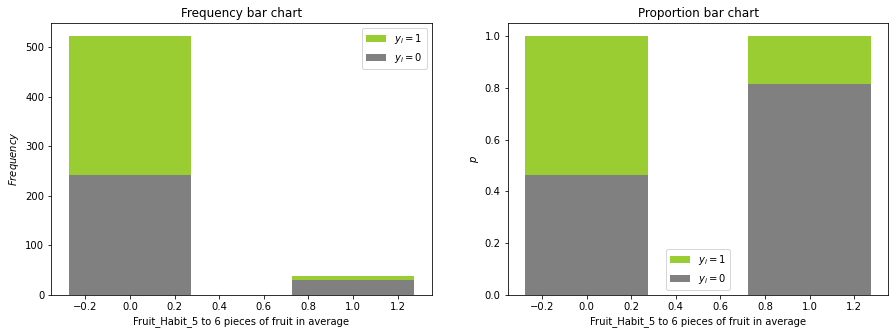

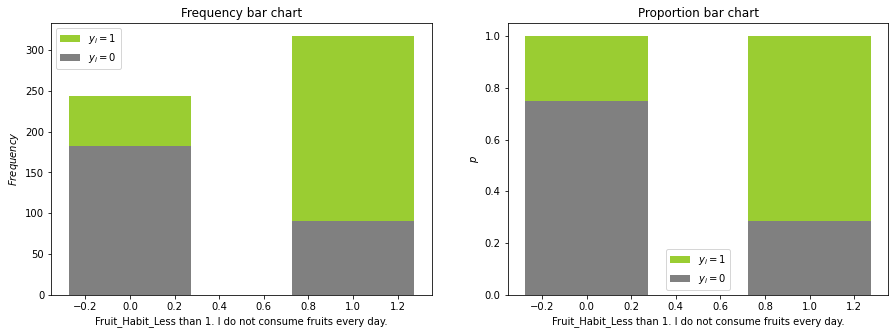

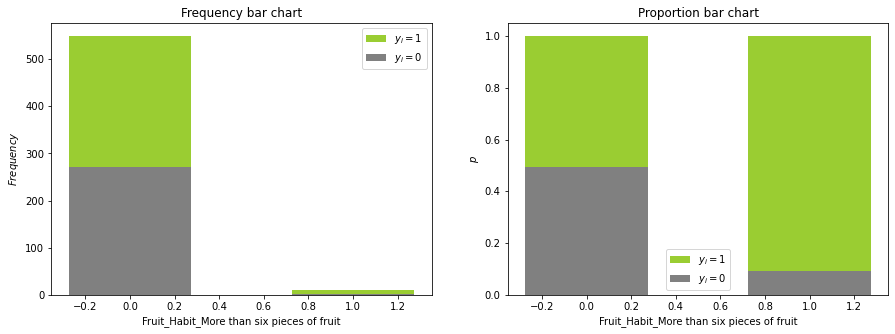

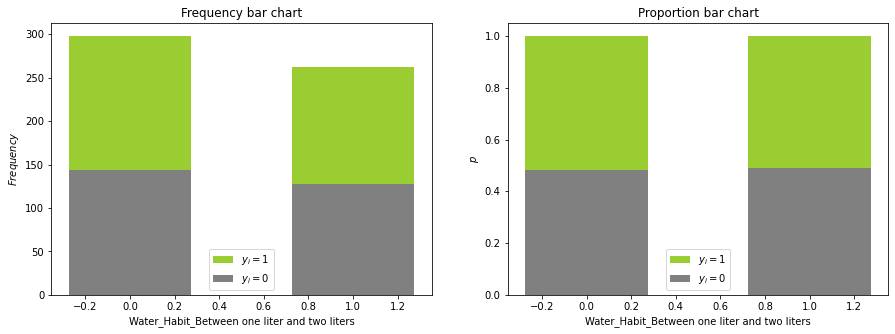

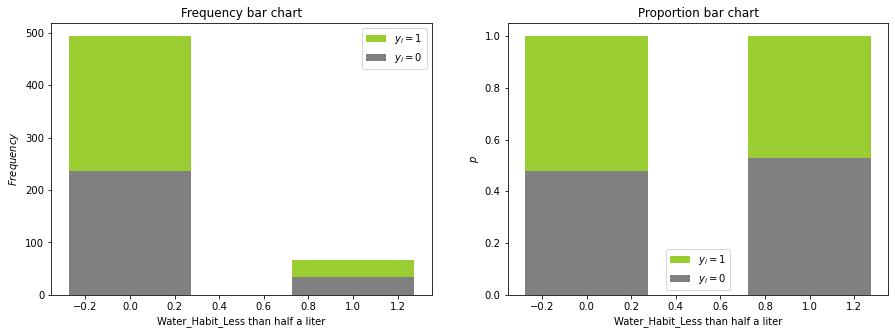

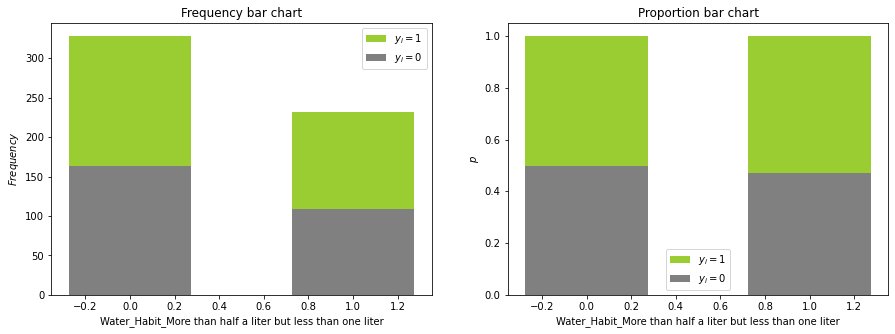

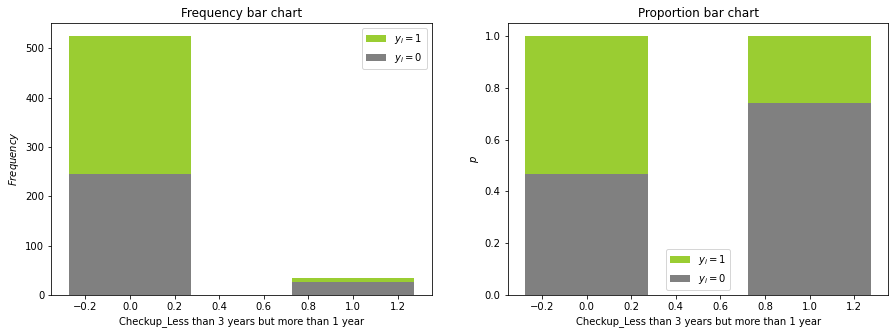

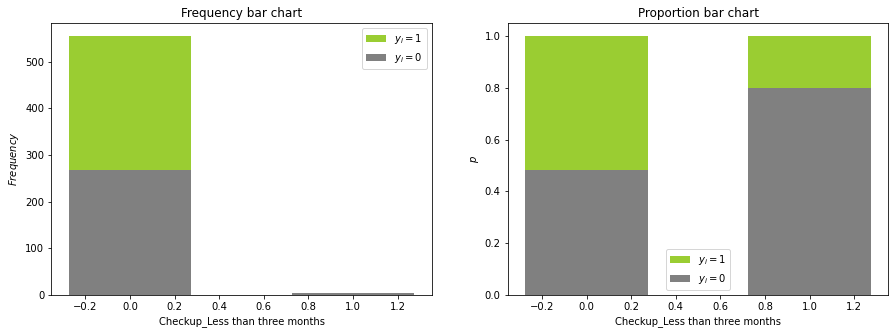

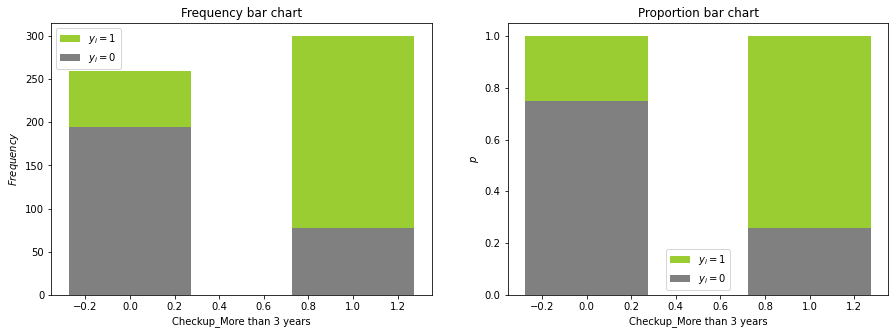

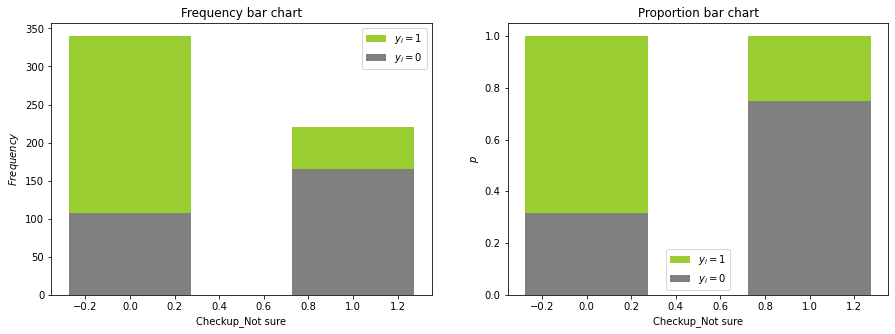

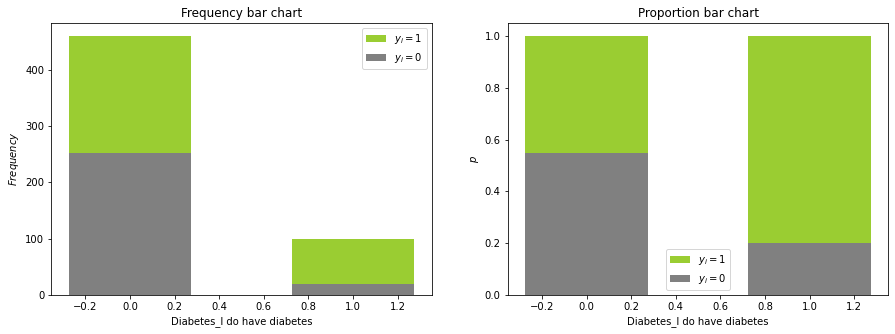

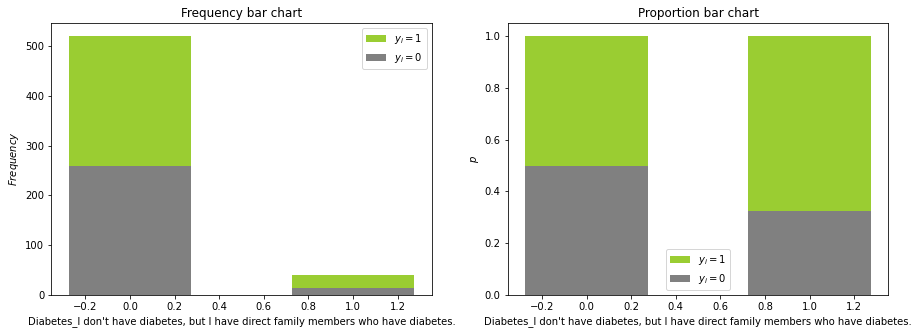

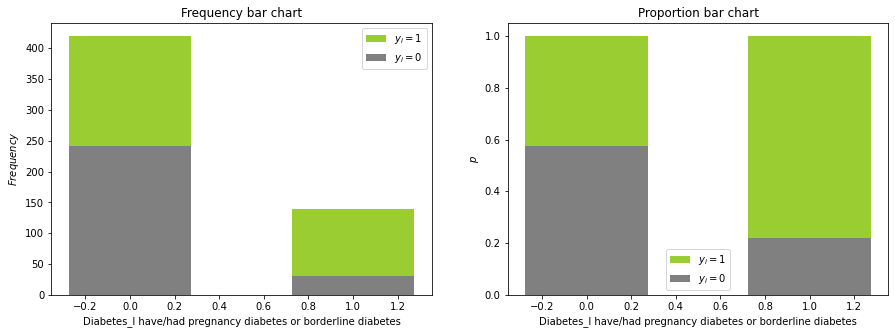

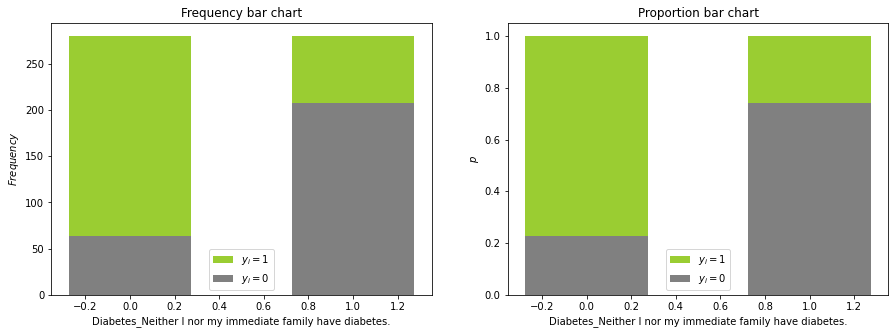

In [33]:
for column in X_train_cat_encoded:
    bar_charts_categorical(Xy_train_scaled, column, "Disease")

## 2. Wrapper Methodes

### 2.1 RFECV with LogisticRegression and only Numerical Variables

In [34]:
model = LogisticRegression(penalty="none")
selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)

c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [35]:
X_train_scaled.columns[selector.support_]

Index(['Birth_Year', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'binary_male', 'BMI', 'age',
       'Region_east midlands', 'Region_east of england', 'Region_london',
       'Region_north east', 'Region_north west', 'Region_west midlands',
       'Education_High School Incomplete (10th to 11th grade)',
       'Education_I never attended school / Other',
       'Education_University Incomplete (1 to 2 years)', 'Smoking_Habit_No',
       'Drinking_Habit_I consider myself a social drinker',
       'Drinking_Habit_I do not consume any type of alcohol',
       'Drinking_Habit_I usually consume alcohol every day', 'Exercise_Yes',
       'Fruit_Habit_1 to 2 pieces of fruit in average',
       'Fruit_Habit_3 to 4 pieces of fruit in average',
       'Fruit_Habit_5 to 6 pieces of fruit in average',
       'Fruit_Habit_Less than 1. I do not consume fruits every day.',
       'Fruit_Habit_More than six pieces of fruit',
       'Water_Habit_

In [36]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  3,
        1, 11,  2,  9,  1,  1,  8,  1,  1,  7,  1,  1,  1, 10,  1,  1,  1,
        1,  1,  1,  5,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1])

In [37]:
bool_table, rank_table = opt_number_features(model,X_train_scaled,y_train,X_val_scaled,y_val,n_max_feature=48)

c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Optimum number of features: 17
the selected features are: ['Birth_Year' 'Height' 'Weight' 'High_Cholesterol' 'Blood_Pressure'
 'Mental_Health' 'Physical_Health' 'binary_male' 'BMI' 'age'
 'Region_east midlands' 'Region_east of england' 'Region_london'
 'Region_north east' 'Region_north west' 'Region_south east'
 'Region_south west' 'Region_west midlands'
 'Region_yorkshire and the humber'
 'Education_Elementary School (1st to 9th grade)'
 'Education_High School Graduate'
 'Education_High School Incomplete (10th to 11th grade)'
 'Education_I never attended school / Other'
 'Education_University Complete (3 or more years)'
 'Education_University Incomplete (1 to 2 years)' 'Smoking_Habit_No'
 'Smoking_Habit_Yes' 'Drinking_Habit_I consider myself a social drinker'
 'Drinking_Habit_I do not consume any type of alcohol'
 'Drinking_Habit_I usually consume alcohol every day' 'Exercise_No'
 'Exercise_Yes' 'Fruit_Habit_1 to 2 pieces of fruit in average'
 'Fruit_Habit_3 to 4 pieces of fruit in av

c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leoal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [38]:
selected_features_encoding = pd.DataFrame(selector.support_, index=X_train_scaled.columns, columns=["RFECV_LR_encoded"])
selected_features_encoding["RFECV_LR_rk_encoded"] = selector.ranking_
selected_features_encoding["RFE_opt_feat_LR_encoded"] = bool_table
selected_features_encoding["RFE_opt_feat_LR_rk_encoded"] = rank_table

### 2.2 RFECV with RandomForrest and only Numerical Variables

In [42]:
model = RandomForestClassifier()
selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)

In [44]:
X_train_scaled.columns[selector.support_]

Index(['Birth_Year', 'High_Cholesterol', 'Blood_Pressure', 'Mental_Health',
       'Physical_Health', 'BMI', 'age',
       'Fruit_Habit_Less than 1. I do not consume fruits every day.',
       'Checkup_More than 3 years',
       'Diabetes_Neither I nor my immediate family have diabetes.'],
      dtype='object')

In [46]:
bool_table, rank_table = opt_number_features(model,X_train_scaled,y_train,X_val_scaled,y_val,n_max_feature=48)

Optimum number of features: 21
the selected features are: ['Birth_Year' 'Height' 'Weight' 'High_Cholesterol' 'Blood_Pressure'
 'Mental_Health' 'Physical_Health' 'binary_male' 'BMI' 'age'
 'Region_east midlands' 'Region_east of england' 'Region_london'
 'Region_north east' 'Region_north west' 'Region_south east'
 'Region_south west' 'Region_west midlands'
 'Region_yorkshire and the humber'
 'Education_Elementary School (1st to 9th grade)'
 'Education_High School Graduate'
 'Education_High School Incomplete (10th to 11th grade)'
 'Education_I never attended school / Other'
 'Education_University Complete (3 or more years)'
 'Education_University Incomplete (1 to 2 years)' 'Smoking_Habit_No'
 'Smoking_Habit_Yes' 'Drinking_Habit_I consider myself a social drinker'
 'Drinking_Habit_I do not consume any type of alcohol'
 'Drinking_Habit_I usually consume alcohol every day' 'Exercise_No'
 'Exercise_Yes' 'Fruit_Habit_1 to 2 pieces of fruit in average'
 'Fruit_Habit_3 to 4 pieces of fruit in av

In [47]:
selected_features_encoding["RFECV_RF_encoded"] = selector.support_
selected_features_encoding["RFECV_RF_rk_encoded"] = selector.ranking_
selected_features_encoding["RFE_opt_feat_RF_encoded"] = bool_table
selected_features_encoding["RFE_opt_feat_RF_rk_encoded"] = rank_table

In [48]:
selected_features_encoding

,RFECV_LR_encoded,RFECV_LR_rk_encoded,RFE_opt_feat_LR_encoded,RFE_opt_feat_LR_rk_encoded,RFECV_RF_encoded,RFECV_RF_rk_encoded,RFE_opt_feat_RF_encoded,RFE_opt_feat_RF_rk_encoded
Birth_Year,True,1,True,1,True,1,True,1
Height,True,1,True,1,False,4,True,1
Weight,True,1,True,1,False,3,True,1
High_Cholesterol,True,1,True,1,True,1,True,1
Blood_Pressure,True,1,True,1,True,1,True,1
Mental_Health,True,1,True,1,True,1,True,1
Physical_Health,True,1,True,1,True,1,True,1
binary_male,True,1,True,1,False,7,True,1
BMI,True,1,True,1,True,1,True,1
age,True,1,False,15,True,1,True,1


## 3. Embedded
### 3.1 Lasso

In [49]:
lasso = LassoCV()
lasso.fit(X_train_scaled, y_train)

coef = pd.Series(lasso.coef_, index = X_train_scaled.columns)
coef.sort_values()

Diabetes_Neither I nor my immediate family have diabetes.                             -2.228333e-01
Physical_Health                                                                       -2.076864e-01
binary_male                                                                           -1.665931e-01
Blood_Pressure                                                                        -6.721288e-02
Fruit_Habit_3 to 4 pieces of fruit in average                                         -4.686000e-02
Checkup_Not sure                                                                      -4.549125e-02
Region_london                                                                         -3.824545e-02
Education_I never attended school / Other                                             -2.976315e-02
Fruit_Habit_1 to 2 pieces of fruit in average                                         -2.006522e-02
Region_east of england                                                                -7.689194e-03


In [50]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 27 variables


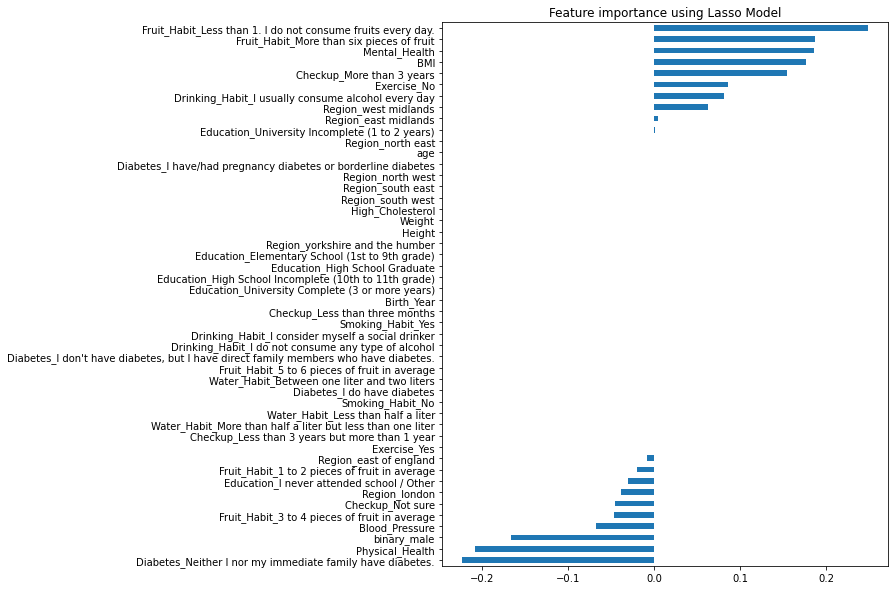

In [51]:
plot_importance(coef, "Lasso")

# Performing a PCA and Repeating analysis

In [72]:
X_train_centered = pd.merge(X_train_num, X_train_cat_encoded, left_index=True, right_index=True)
X_train_centered_array = scale(X_train_centered, with_mean=True, with_std=False)
X_train_centered = pd.DataFrame(X_train_centered_array, index=X_train_centered.index, columns=X_train_centered.columns)

X_val_centered = pd.merge(X_val_num, X_val_cat_encoded, left_index=True, right_index=True)
X_val_centered_array = scale(X_val_centered, with_mean=True, with_std=False)
X_val_centered = pd.DataFrame(X_val_centered_array, index=X_val_centered.index, columns=X_val_centered.columns)

In [73]:
pca = PCA(n_components=0.5)
pca.fit(X_train_centered)

PCA(n_components=0.5)

In [84]:
pca.transform(X_train_centered)

array([[-3.02310764e+00],
       [-4.00481036e+01],
       [-5.52746694e+01],
       [-1.04587373e+02],
       [ 1.74127973e+02],
       [ 3.60102697e+01],
       [-2.19114416e+01],
       [ 3.91298619e+01],
       [ 5.00606309e+01],
       [ 7.33719394e-01],
       [-4.29940998e+01],
       [ 8.45760897e+01],
       [ 5.45622622e+01],
       [-7.00323403e+01],
       [-5.25979740e+00],
       [-2.69075349e+01],
       [ 4.99194728e+01],
       [ 4.90407709e+01],
       [-4.62044107e+00],
       [ 1.08556360e+02],
       [-2.57553793e+01],
       [-4.93187079e+01],
       [ 3.32422739e+01],
       [-4.71394590e-01],
       [-3.56250208e+01],
       [-7.62777476e+01],
       [-2.77658684e+01],
       [ 5.13315331e+01],
       [-5.53634589e+01],
       [ 3.68808009e+01],
       [ 3.76747107e+00],
       [-1.19155670e+01],
       [-5.61843458e+01],
       [-8.86870448e+01],
       [-2.40575850e+01],
       [ 8.33211426e+00],
       [-1.61634009e+01],
       [ 1.06748429e+01],
       [-3.8

In [82]:
X_train_centered

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,binary_male,BMI,age,...,Water_Habit_Less than half a liter,Water_Habit_More than half a liter but less than one liter,Checkup_Less than 3 years but more than 1 year,Checkup_Less than three months,Checkup_More than 3 years,Checkup_Not sure,Diabetes_I do have diabetes,"Diabetes_I don't have diabetes, but I have direct family members who have diabetes.",Diabetes_I have/had pregnancy diabetes or borderline diabetes,Diabetes_Neither I nor my immediate family have diabetes.
PatientID,,,,,,,,,,,,,,,,,,,,,
1646,7.373214,-5.808929,10.085714,-0.871429,-23.610714,0.619643,-4.501786,0.298214,5.660902,-7.373214,...,0.882143,-0.414286,-0.0625,-0.008929,0.464286,-0.392857,-0.178571,-0.071429,0.75,-0.5
1968,1.373214,-0.808929,-15.914286,-40.871429,8.389286,1.619643,10.498214,0.298214,-5.414833,-1.373214,...,-0.117857,-0.414286,-0.0625,-0.008929,-0.535714,0.607143,-0.178571,-0.071429,-0.25,0.5
1180,-8.626786,-5.808929,3.085714,-56.871429,8.389286,-1.380357,14.498214,0.298214,2.993625,8.626786,...,-0.117857,-0.414286,-0.0625,-0.008929,-0.535714,0.607143,-0.178571,-0.071429,-0.25,0.5
1733,10.373214,-1.808929,-13.914286,-102.871429,-23.610714,5.619643,-2.501786,-0.701786,-4.463719,-10.373214,...,-0.117857,-0.414286,-0.0625,-0.008929,0.464286,-0.392857,-0.178571,-0.071429,0.75,-0.5
1665,-10.626786,-10.808929,-5.914286,173.128571,8.389286,1.619643,-1.501786,-0.701786,1.092973,10.626786,...,-0.117857,-0.414286,-0.0625,-0.008929,0.464286,-0.392857,-0.178571,-0.071429,0.75,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,2.373214,-0.808929,-4.914286,-57.871429,-13.610714,9.619643,-4.501786,0.298214,-1.470626,-2.373214,...,-0.117857,0.585714,0.9375,-0.008929,-0.535714,-0.392857,-0.178571,0.928571,-0.25,-0.5
1229,-11.626786,-9.808929,-15.914286,-15.871429,46.389286,3.619643,-0.501786,-0.701786,-3.230182,11.626786,...,-0.117857,-0.414286,-0.0625,-0.008929,-0.535714,0.607143,-0.178571,-0.071429,-0.25,0.5
1270,11.373214,-5.808929,0.085714,-32.871429,-21.610714,2.619643,-4.501786,0.298214,1.850507,-11.373214,...,-0.117857,0.585714,-0.0625,-0.008929,-0.535714,0.607143,-0.178571,-0.071429,-0.25,0.5
